# DGTIC-UNAM: Diplomado en Ciencia de Datos 
## Clasificación de Tumores Cerebrales con Deep Learning

<center>
    <img src="../public/intro_img.jpg" width="800">
</center>

### Nombre: Cristian Armando, Flores Álvarez.
#### ENERO - 2022

### **¿Qué es un tumor cerebral?**

Un tumor cerebral es una masa o bulto de células anormales que se encuentra en el cerebro.

Existen varios tipos de tumores cerebrales. Algunos tumores cerebrales no son cancerosos (benignos) y algunos tumores sí lo son (malignos). Los tumores cerebrales se pueden originar en el cerebro (tumores cerebrales primarios) o el cáncer se puede originar en otras partes del cuerpo y luego extenderse hasta el cerebro (tumores cerebrales secundarios o metastásicos).

https://www.mayoclinic.org/es-es/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084

### La importancia del tema:

La detección temprana y la clasificación de los tumores cerebrales es un dominio de investigación importante en el campo de las imágenes médicas y, en consecuencia, ayuda a seleccionar el método de tratamiento más conveniente para salvar la vida de los pacientes.

### **Metodología**:

Según la Organización Mundial de la Salud (OMS), el diagnóstico adecuado de un tumor cerebral implica la detección, la identificación de la ubicación del tumor cerebral y la clasificación del tumor en función de la malignidad, el grado y el tipo.

En este proyecto exploraremos el uso de un conjunto de Imágenes por Resonancia Magnética (MRI por sus siglas en inglés) para el diagnóstico de tumores cerebrales usando una Red Neuronal Convolucional (CNN), la cual será capaz de detectar la exitencia o no de un tumor cerebral, así como de clasificarlo con base en la ubicación del mismo.

### **Conjunto de datos**

El conjunto de datos utilizado para este proyecto es público y se puede encontrar en la siguiente liga de **Kaggle**: https://www.kaggle.com/masoudnickparvar/brain-tumor-mri-dataset, contiene 7,022 Imágenes por Resonancia Magnética (MRI) reales del cerebro humano, las cuales están clasificadas en 4 clases: **glioma**, **meningioma**, **pituitary** y **no tumor**.

El tamaño de las imágenes es variable, por lo que previo al entrenamiento realizaremos un pre-procesamiento de los datos para homologar el tamaño de las imágenes y el color.

Para mayor información acerca del conjunto de datos visite la liga a la página de **Kaggle**. 

### **Lectura y preprocesamiento de imágenes**

In [1]:
### Importamos Librerías:
from math import floor, ceil, sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
# Cargamos Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
tf.config.run_functions_eagerly(True)

# Algunos hiperparámetros
N_EPOCAS = 30
T_LOTE = 32
T_IMAGEN = 256

# Semillas de los generadores de números pseudoaleatorios para reproducibilidad
np.random.seed(1234)
tf.random.set_seed(1234)

# working path
working_path = '/content/drive/MyDrive/Proyecto_Final_CD'

In [3]:
# %% Lectura de imágenes:
from utils.utils import load_data, muestra_imagenes, serializa_ejemplo, deserializa_ejemplo, plot_labels_freq

# Rutas donde se almacenan las imágenes
path_train = '../data/Training'
path_test = '../data/Testing'

# Categorías de las imágenes de entrenamiento y prueba
train_labels = os.listdir(path_train)
test_labels = os.listdir(path_test)

# Diccionarios de relación etiqueta - target
index_to_str = {i:s for i,s in enumerate(train_labels)}
str_to_index = {s:i for i,s in enumerate(train_labels)}

# Cargamos los datos de entrenamiento y prueba con su correspondiente ruta y etiqueta

imgs_train, labels_train, target_train = load_data(labels=train_labels, path=path_train, str_to_index=str_to_index)
imgs_test, labels_test, target_test = load_data(labels=test_labels, path=path_test, str_to_index=str_to_index)

n_clases = len(train_labels)
n_obs_train = len(imgs_train)
n_obs_test = len(imgs_test)

print(f'Número de clases = {n_clases}\nNúmero de ejemplos en entrenamiento = {n_obs_train}\nNúmero de ejemplos en prueba = {n_obs_test}')

Número de clases = 4
Número de ejemplos en entrenamiento = 5712
Número de ejemplos en prueba = 1311


C:\Users\crist\AppData\Local\Temp/ipykernel_4632/1012754397.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  muestra_imagenes(np.array(m_img), m_etiq)


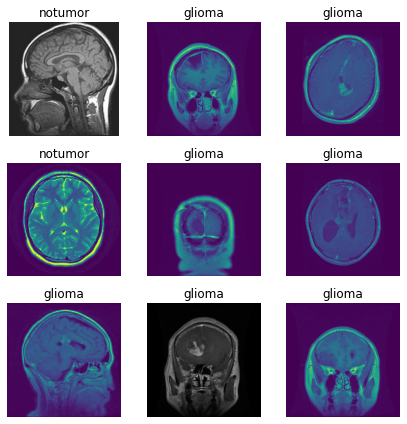

In [4]:
#### Imprimimos algunas imágenes
muestra = np.random.randint(n_obs_train, size = 9)
m_img = [plt.imread(imgs_train[i]) for i in muestra]
m_etiq = [labels_train[i] for i in muestra]
muestra_imagenes(np.array(m_img), m_etiq)

Como podemos obsevar, el tamaño y color de las imágenes son distintos, con el objetivo de homologar ambos aspectos y quitar cierto ruido como marcos, utilizaremos una serie de funciones, (disponibles en el siguiente github: https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py), que nos ayudarán en el preprocesamiento de los datos, al final, todas las imágenes quedarán a escala de grises y de tamaño:  $256 \times 256 \times 3$ 

In [5]:
# Limpieza de imágenes:
from tqdm import tqdm
import imutils
import cv2

def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    return new_img

if __name__ == "__main__":
    training = "../data/Training"
    testing = "../data/Testing"
    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)
    IMG_SIZE = 256
    
    for dir in training_dir:
        save_path = '../data/preprocessing/Training/'+ dir
        path = os.path.join(training,dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path,img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)
    
    for dir in testing_dir:
        save_path = '../data/preprocessing/Testing/'+ dir
        path = os.path.join(testing,dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path,img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)

Ahora leémos las imágenes preprocesadas:

Número de clases = 4
Número de ejemplos en entrenamiento = 5712
Número de ejemplos en prueba = 1311


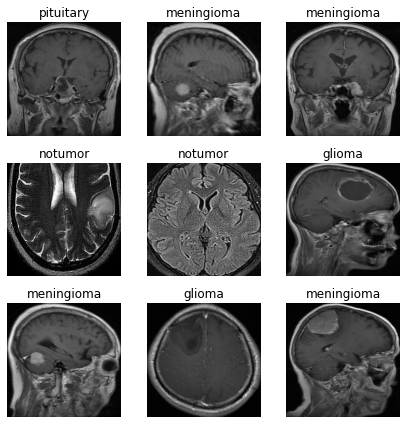

In [5]:
# Rutas donde se almacenan las imágenes (256x256 en escala de grises)
path_train = '../data/preprocessing/Training'
path_test = '../data/preprocessing/Testing'
T_IMAGEN = 256

# Categorías de las imágenes de entrenamiento y prueba
train_labels = os.listdir(path_train)
test_labels = os.listdir(path_test)

# Diccionarios de relación etiqueta - target
index_to_str = {i:s for i,s in enumerate(train_labels)}
str_to_index = {s:i for i,s in enumerate(train_labels)}

imgs_train, labels_train, target_train = load_data(labels=train_labels, path=path_train, str_to_index=str_to_index)
imgs_test, labels_test, target_test = load_data(labels=test_labels, path=path_test, str_to_index=str_to_index)

n_clases = len(train_labels)
n_obs_train = len(imgs_train)
n_obs_test = len(imgs_test)

print(f'Número de clases = {n_clases}\nNúmero de ejemplos en entrenamiento = {n_obs_train}\nNúmero de ejemplos en prueba = {n_obs_test}')

#### Imprimimos algunas imágenes
muestra = np.random.randint(n_obs_train, size = 9)
m_img = [plt.imread(imgs_train[i]) for i in muestra]
m_etiq = [labels_train[i] for i in muestra]
muestra_imagenes(np.array(m_img), m_etiq)

In [6]:
# Rutas donde se almacenan las imágenes (256x256 en escala de grises)
path_train = '../data/preprocessing/Training'
path_test = '../data/preprocessing/Testing'
T_IMAGEN = 256

# Categorías de las imágenes de entrenamiento y prueba
train_labels = os.listdir(path_train)

In [24]:
train_labels

['glioma', 'meningioma', 'notumor', 'pituitary']

Observemos como todas las imágenes ya cuentan con el mismo tamaño ($256 \times 256 \times 3$), están en escala de grises y se quito el ruido de los marcos. 

### **Split de datos en Train / Validation / Test**

Construimos un pandas dataframe con las rutas y etiquetas correspondientes de cada imagen para los datos de entrenamiento y prueba.

In [9]:
df_train = pd.DataFrame(list(zip(imgs_train, labels_train, target_train)), columns =['file', 'label', 'target'])
df_test = pd.DataFrame(list(zip(imgs_test, labels_test, target_test)), columns =['file', 'label', 'target'])
df_test.sample(10)

,file,label,target
1169,../data/preprocessing/Testing/pituitary/Te-pi_...,pituitary,3
1251,../data/preprocessing/Testing/pituitary/Te-pi_...,pituitary,3
266,../data/preprocessing/Testing/glioma/Te-gl_026...,glioma,0
1037,../data/preprocessing/Testing/pituitary/Te-pi_...,pituitary,3
807,../data/preprocessing/Testing/notumor/Te-no_02...,notumor,2
85,../data/preprocessing/Testing/glioma/Te-gl_008...,glioma,0
361,../data/preprocessing/Testing/meningioma/Te-me...,meningioma,1
975,../data/preprocessing/Testing/notumor/Te-no_03...,notumor,2
858,../data/preprocessing/Testing/notumor/Te-no_02...,notumor,2
1265,../data/preprocessing/Testing/pituitary/Te-pi_...,pituitary,3


Separamos los datos de entrenamiento en 80/20 para tener una muestra de validación durante en entrenamiento de la red neuronal convolucional. 

In [10]:
### Partición de los datos de entrenamiento:
n_ent = int(floor(df_train.shape[0] * 0.8))
perm = np.random.permutation(df_train.shape[0])
df_validation = df_train.iloc[perm[n_ent:]]
df_train = df_train.iloc[perm[:n_ent]]

In [11]:
### Guardamos los dataset
df_train.to_csv('../data/csv/df_train.csv',index=False)
df_validation.to_csv('../data/csv/df_validation.csv',index=False)
df_test.to_csv('../data/csv/df_test.csv',index=False)

In [7]:
### Leémos los dataset
df_train = pd.read_csv('../data/csv/df_train.csv')
df_validation = pd.read_csv('../data/csv/df_validation.csv')
df_test = pd.read_csv('../data/csv/df_test.csv')

In [8]:
### Tamaños de cada muestra 
n_train = len(df_train)
n_val = len(df_validation)
n_test = len(df_test)

In [14]:
### Agrupamos cada muestra por categoría para poder graficarlos
df_train_labels = df_train.groupby('label').count()['target'].to_frame().reset_index()
df_val_labels = df_validation.groupby('label').count()['target'].to_frame().reset_index()
df_test_labels = df_test.groupby('label').count()['target'].to_frame().reset_index()
df_train_labels['freq_relative'] = df_train_labels['target']/n_train
df_val_labels['freq_relative'] = df_val_labels['target']/n_val
df_test_labels['freq_relative'] = df_test_labels['target']/n_test

Visualicemos el % de cada categoría en todos las muestras: entrenamiento, validación y prueba.

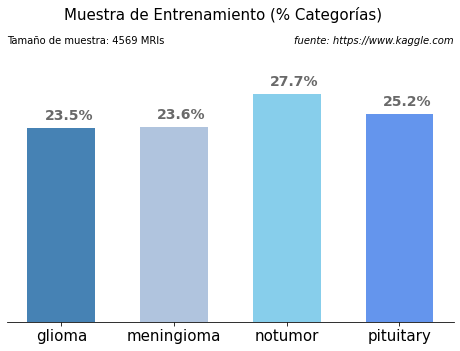

In [15]:
plot_labels_freq(df=df_train_labels,n_obs=n_train,sample='Entrenamiento',label_col='label',freq_col='freq_relative')

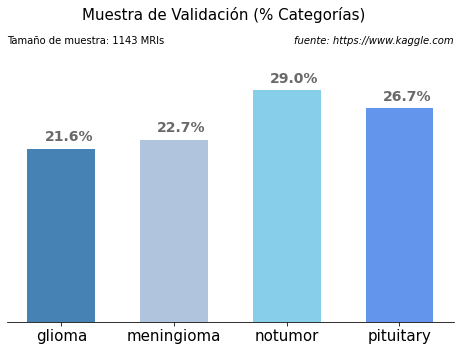

In [16]:
plot_labels_freq(df=df_val_labels,n_obs=n_val,sample='Validación',label_col='label',freq_col='freq_relative')

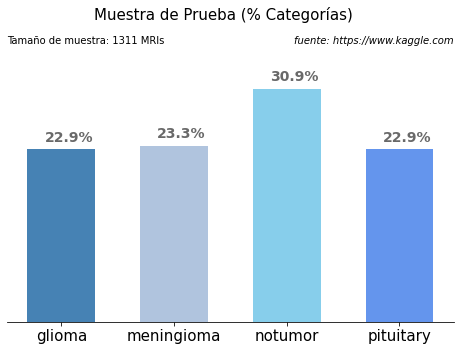

In [17]:
plot_labels_freq(df=df_test_labels,n_obs=n_test,sample='Prueba',label_col='label',freq_col='freq_relative')

### **Serialización de las MRIs para guardarlas como TFRecords**

Generamos funciones (ver utils.py) para leer y preprocesar nuestras imágenes de entrenamiento y validación como archivos TFRecords, este formato es necesario para poder entrenar la Red Neuronal Convolucional (CNN) con TensorFlow. 

In [18]:
tfr_ent = '../data/TFRecords/train_images.tfrecords'
with tf.io.TFRecordWriter(tfr_ent) as writer:
    for ruta,etiqueta in zip(df_train['file'], df_train['target']):
        tfr_ej = serializa_ejemplo(ruta=ruta, etiqueta=etiqueta,image_size=T_IMAGEN)
        writer.write(tfr_ej.SerializeToString())

tfr_val = '../data/TFRecords/validation_images.tfrecords'
with tf.io.TFRecordWriter(tfr_val) as writer:
    for ruta,etiqueta in zip(df_validation['file'], df_validation['target']):
        tf_ejr = serializa_ejemplo(ruta=ruta, etiqueta=etiqueta,image_size=T_IMAGEN)
        writer.write(tf_ejr.SerializeToString())

tfr_test = '../data/TFRecords/test_images.tfrecords'
with tf.io.TFRecordWriter(tfr_test) as writer:
    for ruta,etiqueta in zip(df_test['file'], df_test['target']):
        tf_ejr = serializa_ejemplo(ruta=ruta, etiqueta=etiqueta,image_size=T_IMAGEN)
        writer.write(tf_ejr.SerializeToString())

### **Entrenamiento de la CNN**

Por motivos de capacidad de procesamiento, el entrenamiento de la Red Neuronal Convolucional (CNN) se hará con Google Colaboratory, para ello, subiremos los datos de entrenamiento, validación y prueba en formato tfrecords a Google Drive y de ahí lo cargaremos a Colab para poder trabajar con ellos usando GPUs.

### Aumento de datos

In [9]:
# working path
working_path = '../data'

### Aumento de datos:
aumento_datos = tf.keras.Sequential([
                                    RandomFlip("horizontal_and_vertical"),
                                    RandomRotation(factor=0.3),
                                    RandomZoom(height_factor=0.2,
                                        width_factor=0.2)
                                    ])

In [10]:
### Carga de TFRecords

## Entrenamiento (A esta muestra le hacemos aumento de datos con el objetivo de tener mayor variabilidad en el entrenamiento)
train_ds = tf.data.TFRecordDataset(os.path.join(working_path,'TFRecords','train_images.tfrecords'), 
                                 buffer_size = 100, 
                                 num_parallel_reads=8)

train_ds = train_ds.shuffle(n_train)
train_ds = train_ds.map(deserializa_ejemplo, num_parallel_calls=8)
train_ds = train_ds.map(lambda x, y: (aumento_datos(x), y), num_parallel_calls=8)
train_ds = train_ds.batch(T_LOTE)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Validación

validation_ds = tf.data.TFRecordDataset(os.path.join(working_path,'TFRecords','validation_images.tfrecords'), 
                                    buffer_size = 100, 
                                    num_parallel_reads = 8)
validation_ds = validation_ds.map(deserializa_ejemplo)
validation_ds = validation_ds.batch(1)


## Prueba

test_ds = tf.data.TFRecordDataset(os.path.join(working_path,'TFRecords','test_images.tfrecords'), 
                                    buffer_size = 100, 
                                    num_parallel_reads = 8)
test_ds = test_ds.map(deserializa_ejemplo)
test_ds = test_ds.batch(1)

C:\Users\crist\anaconda3\envs\tf2.6\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


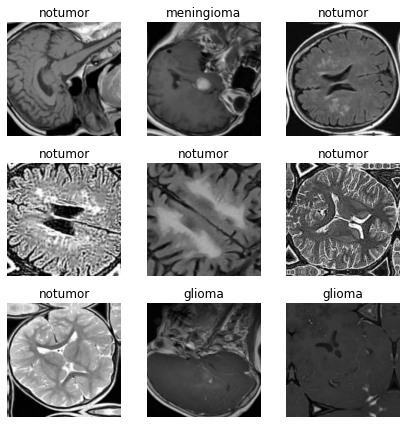

In [11]:
### Mostramos algunas imágenes:

lote_muestra = list(train_ds.take(1))[0]
imgs_muestra = lote_muestra[0][:9].numpy()
# str_to_index
etiq_muestra = [index_to_str[c] for c in lote_muestra[1][:9].numpy()]
muestra_imagenes(imgs_muestra, etiq_muestra)

### **Definición de la CNN**

In [29]:
## Definición de la CNN
## Ahora vamos a definir una red neuronal convolucional simple con bloques de tipo residual:

class Residual(tf.keras.Model):
    def __init__(self, n_filtros, aumenta = False):  
        super().__init__()
        self.conv1 = Conv2D(n_filtros, 3, padding = 'same')
        self.bn1 = BatchNormalization(axis = 3)
        self.conv2 = Conv2D(n_filtros, 3, padding = 'same')
        self.bn2 = BatchNormalization(axis = 3)
        self.conv1x1 = Conv2D(n_filtros, 1) if aumenta else None
    
    def call(self, x):
        y = self.conv1(x)
        y = tf.keras.activations.relu(y)
        y = self.conv2(y)
        y = self.bn2(y)
        if self.conv1x1:
            x = self.conv1x1(x)
        return tf.keras.activations.relu(x + y)

## Probamos nuestro bloque residual con una imagen:

#res = Residual(3)
#print(res(imgs_muestra[0:1]).shape)

In [30]:
## Definimos un bloque ResNet con bloques residuales:

class BloqueResNet(tf.keras.Model):
    def __init__(self, mapas_ent, mapas_sal, k = 2):
        super().__init__()
        self.res = [Residual(mapas_sal, aumenta = mapas_ent != mapas_sal) for _ in range(k)]
    
    def call(self, x):
        for r in self.res:
            x = r(x)
        return x

## Pasamos una imagen por nuestro bloque ResNet para probarlo.

#b = BloqueResNet(3, 3)
#print(b(imgs_muestra[0:1]).shape)

In [31]:
class ResNet18(tf.keras.Model):
    def __init__(self, n_clases):
        super().__init__()
        self.conv1 = Conv2D(256, kernel_size = 7, strides = 2)
        self.mp1 = MaxPooling2D(pool_size = 3, strides = 2)
        self.b1 = BloqueResNet(256, 256, 2)
        self.b2 = BloqueResNet(256, 512, 2)
        self.b3 = BloqueResNet(512, 256, 2)
        self.b4 = BloqueResNet(256, 128, 2)
        self.gap = GlobalAveragePooling2D()
        self.densa = Dense(n_clases, activation='softmax')
    
    def call(self, x): 
        x = self.conv1(x)
        x = self.mp1(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.gap(x)
        return self.densa(x)

In [32]:
@tf.function
def paso_ent(x, y, modelo, fn_perdida, optimizador):
    with tf.GradientTape() as cinta:
        y_pred = modelo(x)
        perdida = fn_perdida(y, y_pred)
    gradientes = cinta.gradient(perdida, modelo.trainable_variables)
    optimizador.apply_gradients(zip(gradientes, modelo.trainable_variables))
    return y_pred

@tf.function
def paso_prueba(imagen, modelo):
    return modelo(imagen)

In [33]:
n_clases = len(train_labels)
modelo = ResNet18(n_clases=n_clases)
modelo.build(input_shape=(None, T_IMAGEN, T_IMAGEN, 3))
modelo.summary()

Model: "res_net18_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          multiple                  37888     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 bloque_res_net_4 (BloqueRes  multiple                 2364416   
 Net)                                                            
                                                                 
 bloque_res_net_5 (BloqueRes  multiple                 8662016   
 Net)                                                            
                                                                 
 bloque_res_net_6 (BloqueRes  multiple                 3151360   
 Net)                                                  

In [20]:
#print(modelo(imgs_muestra[0:1])[0])

In [34]:
## Con las funciones definidas anteriormente entrenamos nuestra red optimizando la función de entropía cruzada categórica:

fn_perdida = tf.keras.losses.SparseCategoricalCrossentropy()
optimizador = tf.keras.optimizers.Adam(learning_rate=1e-3)

ecc_ent = tf.keras.metrics.SparseCategoricalCrossentropy()
exactitud_ent = tf.keras.metrics.SparseCategoricalAccuracy()

ecc_val = tf.keras.metrics.SparseCategoricalCrossentropy()
exactitud_val = tf.keras.metrics.SparseCategoricalAccuracy()

hist_ecc_ent = []
hist_exactitud_ent = []

hist_ecc_val = []
hist_exactitud_val = []

ecc_val_min = np.inf

### Entrenamiento por épocas

In [ ]:
for epoca in range(N_EPOCAS):
    for paso, (x, y) in enumerate(train_ds):
        y_pred = paso_ent(x, y,  modelo, fn_perdida, optimizador)
        ecc_ent(y, y_pred)
        exactitud_ent(y, y_pred)
        
    for (x, y) in validation_ds:
        y_pred = paso_prueba(x, modelo)
        ecc_val(y, y_pred)
        exactitud_val(y, y_pred)
    
    ecc_ent_res = ecc_ent.result().numpy()
    exactitud_ent_res = exactitud_ent.result().numpy() * 100
    ecc_ent.reset_states()
    exactitud_ent.reset_states()
    hist_ecc_ent.append(ecc_ent_res)
    hist_exactitud_ent.append(exactitud_ent_res)
    
    ecc_val_res = ecc_val.result().numpy()
    exactitud_val_res = exactitud_val.result().numpy() * 100
    ecc_val.reset_states()
    exactitud_val.reset_states()
    hist_ecc_val.append(ecc_val_res)
    hist_exactitud_val.append(exactitud_val_res)
      
    print('E{:2d} ECC(E)={:6.2f}, Exactidud(E)={:6.2f} ECC(V)={:6.2f} Exactitud(V)={:6.2f}'.format(epoca, 
                                                                                                   ecc_ent_res, 
                                                                                                   exactitud_ent_res,
                                                                                                   ecc_val_res, 
                                                                                                   exactitud_val_res))
    
    # Mantenemos el valor de la ECC mínima en validación y los parámetros en
    # el modelo correspondiente
    if ecc_val_min > ecc_val_res:
        ecc_val_min = ecc_val_res
        mejor_modelo_val = modelo.get_weights()

In [ ]:
exactitud_prueba = tf.keras.metrics.SparseCategoricalAccuracy()
for i, (x, y) in enumerate(test_ds):
    y_pred = paso_prueba(x, modelo)
    exactitud_prueba(y, y_pred)

exactitud_prueba = exactitud_prueba.result().numpy() * 100
print("Exactitud en el conjunto de prueba: {:02.2f}%".format(exactitud_prueba))

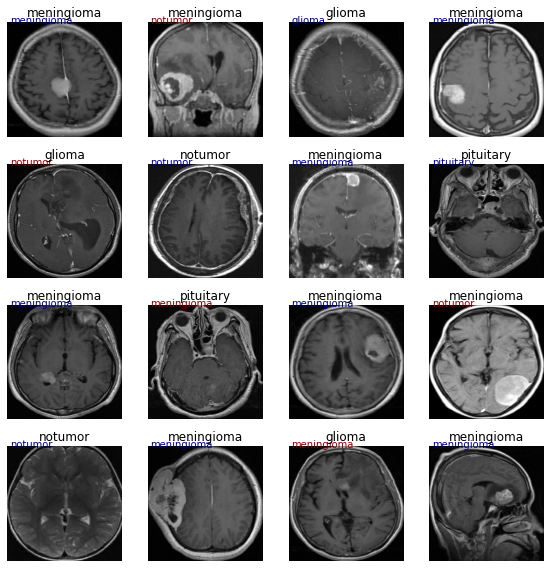

In [22]:
test_ds = test_ds.shuffle(n_test)

imgs_muestra = []
etiq_muestra = []
pred_muestra = []
for i,c in test_ds.take(16):
    pred_muestra.append(index_to_str[tf.argmax(modelo(i)[0]).numpy()])
    imgs_muestra.append(i[0].numpy())
    etiq_muestra.append(index_to_str[c[0].numpy()])

muestra_imagenes(np.array(imgs_muestra), etiq_muestra, pred_muestra)

### Guardamos el modelo

In [ ]:
path_model = '../'
path_save_model = os.path.join(path_model,'Proyecto_Final_CD','modelo','cnn_brain_tumors.h5')
tf.saved_model.save(modelo, path_save_model)

In [16]:
epoc = list(range(1,31))

In [17]:
df = pd.DataFrame(list(zip(epoc,hist_ecc_ent, hist_exactitud_ent,hist_ecc_val,hist_exactitud_val)),
               columns =['Epoc','ECC_Train', 'Acc_Train','ECC_Val','Acc_Val'])
df

,Epoc,ECC_Train,Acc_Train,ECC_Val,Acc_Val
0,1,1.743559,27.248850,1.384231,26.596674
1,2,1.362771,28.780916,1.325538,39.807525
2,3,1.190044,43.335521,1.151612,40.857393
3,4,1.148880,46.596628,1.168642,40.507436
4,5,1.094847,50.164151,0.991519,55.905509
5,6,1.055119,54.169405,1.430731,35.870516
6,7,1.069381,53.928649,0.894055,60.717410
7,8,1.011357,57.561833,0.918679,62.729657
8,9,0.981482,58.459181,0.861897,64.829397
9,10,0.935536,61.063689,0.825353,68.941385


### Graficamos los learning Curves

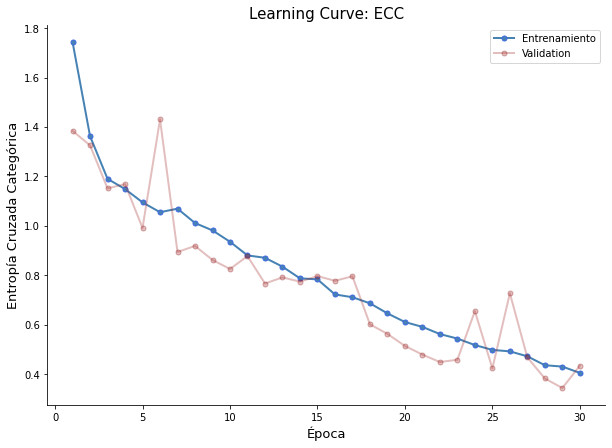

In [18]:
fig = plt.figure(figsize = (10, 7))
plt.plot(df['Epoc'],df['ECC_Train'],label="Entrenamiento",color='steelblue',linewidth=2,marker='.',markersize=10, markeredgecolor='royalblue')
plt.plot(df['Epoc'],df['ECC_Val'],label="Validation",color='brown',linewidth=2,marker='.',markersize=10, markeredgecolor='maroon',alpha=0.3)


plt.title("Learning Curve: ECC",fontdict={'fontsize': 15})
plt.xlabel("Época",fontdict={'fontsize': 13})
plt.ylabel("Entropía Cruzada Categórica",fontdict={'fontsize': 13})
plt.legend()
ejes = fig.axes
ejes[0].spines['right'].set_visible(False)
ejes[0].spines['top'].set_visible(False)
plt.show()

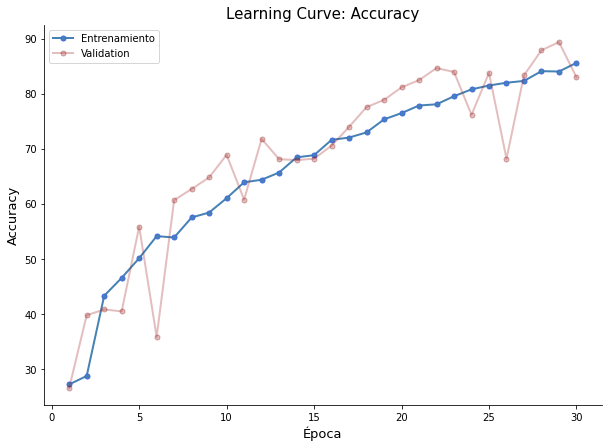

In [19]:
fig = plt.figure(figsize = (10, 7))
plt.plot(df['Epoc'],df['Acc_Train'],label="Entrenamiento",color='steelblue',linewidth=2,marker='.',markersize=10, markeredgecolor='royalblue')
plt.plot(df['Epoc'],df['Acc_Val'],label="Validation",color='brown',linewidth=2,marker='.',markersize=10, markeredgecolor='maroon',alpha=0.3)


plt.title("Learning Curve: Accuracy",fontdict={'fontsize': 15})
plt.xlabel("Época",fontdict={'fontsize': 13})
plt.ylabel("Accuracy",fontdict={'fontsize': 13})
plt.legend()
ejes = fig.axes
ejes[0].spines['right'].set_visible(False)
ejes[0].spines['top'].set_visible(False)

plt.show()